In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import re

In [3]:
train_file = 'train_1.csv'
key_file = 'key_2.csv'

input_df = pd.read_csv('./data/' + train_file)
# input_df_dates = input_df.columns[1:]
input_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [4]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


## Using regular expression to separate for different languages

In [5]:
def lang(Page):
    val = re.search('[a-z][a-z].wikipedia.org',Page)
    if val:
        return val[0][0:2]               
    return 'no_lang'

input_df['language'] = input_df.Page.map(lang)

language_set = {}
language_set['en'] = input_df[input_df.language=='en'].iloc[:,0:-1]
language_set['ja'] = input_df[input_df.language == 'ja'].iloc[:, 0:-1]
language_set['de'] = input_df[input_df.language == 'de'].iloc[:, 0:-1]
language_set['fr'] = input_df[input_df.language == 'fr'].iloc[:, 0:-1]
language_set['ru'] = input_df[input_df.language == 'ru'].iloc[:, 0:-1]
language_set['es'] = input_df[input_df.language == 'es'].iloc[:, 0:-1]
language_set['no_lang'] = input_df[input_df.language == 'no_lang'].iloc[:, 0:-1]

Summing up all the views for a day and for particular language 

In [6]:
total_view = {} 
for key in language_set:
    total_view[key] = language_set[key].iloc[:, 1:].sum(axis=0) / language_set[key].shape[0]

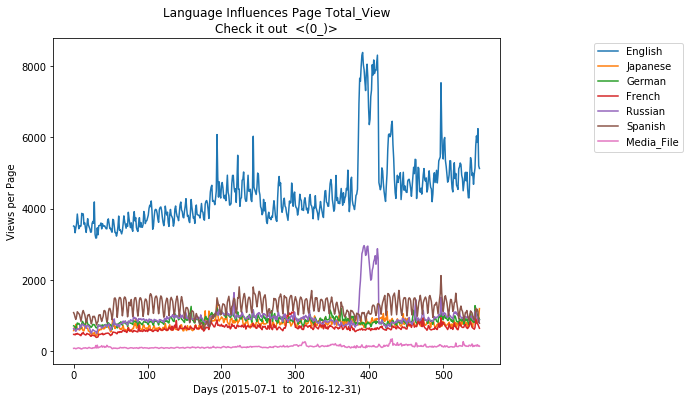

In [7]:
days = [r for r in range(total_view['en'].shape[0])]

plt.figure(figsize=(8, 6))
labels={'ja':'Japanese','de':'German','en' : 'English','no_lang':'Media_File','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'}

for key in total_view:
    plt.plot(days,total_view[key],label = labels[key])
    

plt.ylabel('Views per Page')
plt.xlabel('Days (2015-07-1  to  2016-12-31)')
plt.title('Language Influences Page Total_View\nCheck it out  <(0_)>')
plt.legend(loc = 'upper left', bbox_to_anchor = (1.2, 1))
plt.show()

Now we create our own model using keras. Here I have used LSTM layer but another approach is using multiple layers 1D CNN

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


/home/parth/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


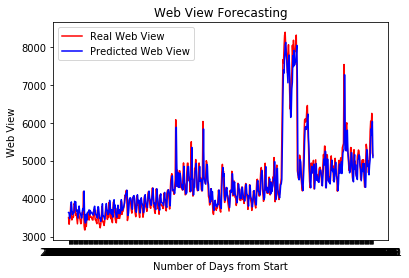

In [29]:
data = total_view['en']

X = data[0:549]
y = data[1:550]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
sc = MinMaxScaler()
X_train = np.reshape(X_train,(-1,1))
y_train = np.reshape(y_train,(-1,1))
X_train = sc.fit_transform(X_train)
y_train = sc.fit_transform(y_train)
X_train = np.reshape(X_train, (384,1,1))

model = Sequential()
model.add(LSTM(units = 64, activation = 'relu', input_shape = (None, 1)))
# model.add(LSTM(units = 32))
model.add(Dense(units = 1))
model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

model.fit(X_train, y_train, batch_size = 32, epochs = 100, verbose = 0)

inputs = X
inputs = np.reshape(inputs,(-1,1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (549,1,1))
y_pred = model.predict(inputs)
y_pred = sc.inverse_transform(y_pred)

plt.plot(y, color = 'red', label = 'Real Web View')
plt.plot(y_pred, color = 'blue', label = 'Predicted Web View')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days from Start')
plt.ylabel('Web View')
plt.legend()
plt.show()